# Calculate permeability of sand-clay mixtures

Calculate permeability of sediment mixtures (ie mixtures of clay and granular material (sand, silt) and compare with emasured values. The calculation of permeability uses a series of equations by Luijendijk and Gleeson (2015, Geofluids 15, or Crustal permeability book chapter 2016) ([link](https://onlinelibrary.wiley.com/doi/full/10.1111/gfl.12115)).

## Import modules

In [47]:
import string
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as pl

## Select dataset:

In [48]:
# file containing porosity & permeability data
# uncomment (remove the # sign) one of the filenames below:

# pure sand (Fountainbleau sandstone, Bourbie & Zinsner 1985):
#fn = 'data/porperm_Bourbie1985_Fontainebleau_sandstone.csv'

# pure clay, compilation of clay permeability data from different data sources (Olsen 1966; Mesri & Olson 1971; Al-Tabbaa & Wood 1987; Vasseur et al. 1995)
#fn = 'data/porperm_compilation_clays.csv'

# lab-mixed kaolinite & sand by Knoll (1996):
fn = 'data/porperm_kaoline_sand_mix_Knoll1996.csv'

# mixed sediments from the Roer Valley Graben:
#fn = 'data/porperm_data_well_AST02_with_spec_surf.csv'

# example dataset using a sample from IODP leg ...:
#fn = 'data/example_dataset_seafloor_sediments_with_spec_surf.csv'



## Define some parameters

In [49]:

# percolation threshold for porosity, used for calculating effective porosity for Kozeny-Carman equation
phi_threshold = 0.025

# Kozeny-Carman constant
C = 5.0

# density of rock matrix and pore water
rho_s = 2650.0
rho_w = 1025.0

# empirical constants for permeability-void ratio equation for kaolinite, illite, smectite
# these values were calibrated to a compilation of permeability data for different clay minerals
# see Luijendijk & Gleeson (2015, Geofluids) for more info
clays = ['kaolinite', 'illite', 'smectite']
k0_clays = 10 ** np.array([-16.21014136, -18.81362945, -20.92831503])
m_clays = np.array([3.60952787, 3.57637639, 3.01368043])

# note that for the Knoll (1996) dataset one should use a much higher reference (k0) permeability for kaolinite. The reason for this is unknown:
if 'Knoll1996' in fn:
    k0_clays[0] = 10 ** (np.log10(k0_clays[0]) + 0.78)

# power mean exponent. 
# This governs if the permeability of the sediment mixture is calculated as the harmonic mean, geometric mean or arithmetic mean, 
# or something in between. Use p=-1 for harmonic mean, p=0 for geometric mean or p=1 for arithmetic mean
# Luijendijk and Gleeson (2015) suggest that p=0 would be the best value for first order estiamtes of permeability vairation
# however this has only been tested on a relatively small dataset, and it may be dependent on the type and size of samples, internal structure of samples,
# depositional environments etc...
power_mean_exponent = 0.0

# colormap, see here for some other option: https://matplotlib.org/users/colormaps.html
cmap = 'copper_r'

# type of figure to save. you can choose png, svg, pdf, jpg etc.. see matplotlib savefig documentation for more info
figure_extension = 'png'

In [50]:
k0_clays_mod = 10 ** (np.log10(k0_clays[0]) + 0.78)
k0_clays_mod

2.2379925681278053e-15

## Load porosity, clay content, clay type and specific surface data

In [51]:
df = pd.read_csv(fn)
df.head()

,sample,clay_fraction,porosity,permeability_measured,kaolinite_fraction,illite_fraction,smectite_fraction,specific_surface_granular_fraction
0,1,0.000,0.399,4.400000e-10,1,0,0,4.7
1,2,0.062,0.359,7.500000e-13,1,0,0,4.7
2,3,0.129,0.308,1.600000e-14,1,0,0,4.7
3,4,0.209,0.238,5.400000e-16,1,0,0,4.7
4,5,0.372,0.359,7.100000e-16,1,0,0,4.7


## Calculate permeabiltiy of clay fraction

In [52]:
def calculate_k_clay_exponential(porosity, k0, m):
    
    """
    calculate permeability as an exponential function of void ratio 
    """
    
    void_ratio = porosity / (1.0 - porosity)
    
    return k0 * void_ratio**m

In [53]:
## first calculate permeability for each clay mineral:
for clay, k0_clay, m_clay in zip(clays, k0_clays, m_clays):
    df['k_%s' % clay] = calculate_k_clay_exponential(df['porosity'], k0_clay, m_clay)
    
# combine estimates and take the geometric mean:
df['k_clay'] = 0
for clay in clays:
    df['k_clay'] += df['%s_fraction' % clay] * np.log10(df['k_%s' % clay])
df['k_clay'] = 10**df['k_clay']

## Calculate permeability of granular fraction using the Kozeny-Carman eq.

In [54]:
def kozeny_carman(phi, C, Sa, rho_s, rho_w, phi_eff):
    
    """
    Kozeny-Carman equation
    
    """
    #phi_eff = phi - phi_threshold
    rho = phi * rho_w + (1.0 - phi) * rho_s
    
    # calculate specific surface per volume instead of per kg    
    Sa_vol = Sa * (1.0 - phi) * rho_s
    
    # calculate permeability
    k = (1.0 / (C * Sa_vol**2)) * phi_eff**3 / (1.0 - phi_eff)**2
    
    return k

In [55]:
phi = df['porosity']
phi_eff = df['porosity'] - phi_threshold
Sa = df['specific_surface_granular_fraction']
df['k_granular'] = kozeny_carman(phi, C, Sa, rho_s, rho_w, phi_eff)

## Calculate the permeability of the sediment mixture

In [56]:
def power_mean(p, w, k1, k2):

    """
    calculate power mean of two components
    reduces to arithmetic mean for p=1 and harmonic mean for p=-1
    returns the geomteric mean for p=0

    """
    
    if p!=0:
        k_calc = (w*k1**p + (1-w)*k2**p)**(1.0/p)
    
    elif p == 0:
        k_calc = np.exp(w*np.log(k1) + (1-w)*np.log(k2))
        
    # find pure clay samples
    ind_sand = w == 0
    k_calc[ind_sand] = k2
    
    # find pure sand samples
    ind_clay = w == 1.0
    k_calc[ind_clay] = k1
    
    return k_calc

In [57]:
df['power_mean_exponent'] = power_mean_exponent
df['k_calculated'] = power_mean(power_mean_exponent, df['clay_fraction'], df['k_clay'], df['k_granular'])

print('added column with calculated permeability values to .csv file:')
df['k_calculated'].head()

added column with calculated permeability values to .csv file:


0    4.764965e-10
1    1.004175e-10
2    1.587320e-11
3    1.317312e-12
4    8.058782e-13
Name: k_calculated, dtype: float64

## Save permeability data to a csv file

In [58]:
fno = fn[:-4] + '_with_calculated_k.csv'
df.to_csv(fno)
print('saved csv file with calculated permeability as %s' % fno)

saved csv file with calculated permeability as data/porperm_kaoline_sand_mix_Knoll1996_with_calculated_k.csv


## Make some figures of measured vs calculated permeability

### Measured vs calculated permeability

In [59]:
klims = (np.min(np.log10(df['permeability_measured'])), np.max(np.log10(df['permeability_measured'])))

saving figure as  figs/porperm_kaoline_sand_mix_Knoll1996_measured_vs_calculated_k.png


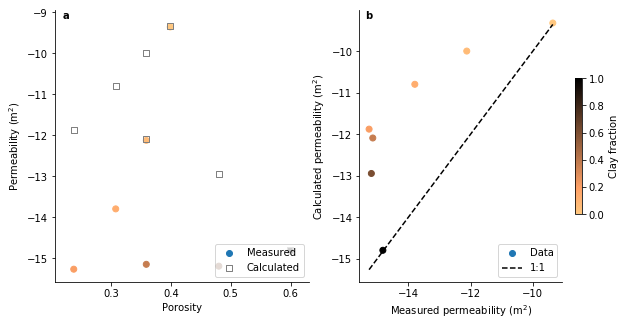

In [60]:
fig, axs = pl.subplots(1, 2, figsize=(10, 5))



sckm = axs[0].scatter(df['porosity'], np.log10(df['permeability_measured']), c=df['clay_fraction'], 
                      vmin=0.0, vmax=1.0, cmap=cmap)

sckc = axs[0].scatter(df['porosity'], np.log10(df['k_calculated']), 
                      edgecolor='gray', facecolor='None', marker='s')

legs = [sckm, sckc]
labels = [r'Measured', r'Calculated']
axs[0].legend(legs, labels, frameon=True, loc='lower right')

axs[0].set_xlabel('Porosity')
axs[0].set_ylabel(r'Permeability (m$^2$)')

#################
# second panel:
#################
sc = axs[1].scatter(np.log10(df['permeability_measured']), np.log10(df['k_calculated']), c=df['clay_fraction'], 
                    vmin=0.0, vmax=1.0, cmap=cmap)

l11 = axs[1].plot(klims, klims, ls='--', color='black')

cb = fig.colorbar(sckm, shrink=0.5)
cb.set_label('Clay fraction')

axs[1].set_xlabel(r'Measured permeability (m$^2$)')
axs[1].set_ylabel(r'Calculated permeability (m$^2$)')

axs[1].legend([sc, l11[0]], ['Data', '1:1'], loc='lower right', frameon=True)

# make the figure look nicer:
for i, panel in enumerate(axs):
    panel.spines['top'].set_visible(False)
    panel.spines['right'].set_visible(False)
    panel.text(0.03, 1.0, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='top', fontsize='medium')

fn1 = os.path.split(fn)[-1][:-4]
fn2 = fn1 + '_measured_vs_calculated_k.%s' % figure_extension
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn, dpi=300)

**Fig caption** *Measured vs calculated permeability using the power mean of the permeability of the granular and clay fractions*

### Normalized difference of measured permeability and the theoretical permeability of the granular and clay fractions

In [61]:
# calculate k offset using clay composition estimates for datasets
df['k_offset'] = \
    (np.log10(df['permeability_measured']) - np.log10(df['k_clay'])) / \
    (np.log10(df['k_granular']) - np.log10(df['k_clay']))

In [62]:
# load permeability vs clay content model Revil (2002)
dfr = pd.read_csv('data/simulated_k_revil1999_model.csv')

saving figure as  figs/porperm_kaoline_sand_mix_Knoll1996_normalized_k.png


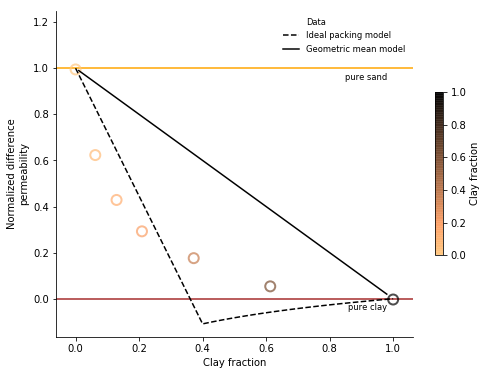

In [63]:
fig, ax = pl.subplots(1, 1, figsize=(8, 6))

# plot data
sc = ax.scatter(df['clay_fraction'], df['k_offset'], c=df['clay_fraction'], s=100, lw=2.0, 
                vmin=0.0, vmax=1.0, cmap=cmap, alpha=0.7)

sc.set_facecolor('none')

# plot theoretical geometric mean k of clay and sand fractions in panel d
w_plot = np.arange(0.01, 0.99, 0.01)
k0 = 1
k1 = 10
geom_mean = power_mean(0.0, w_plot, k0, k1)
leg_dfg, = ax.plot(w_plot, np.log10(geom_mean), color='black', ls='-')
leg_dfm, = ax.plot(dfr['cv'], dfr['k_normalized_Knoll1996'], color='black', ls='--')

# add lines for theoretical permeability pure granular or clay components
xmax = 1.0
leg_k_sd = ax.axhline(y=1, color='orange', ls='-', lw=1.5, zorder=0)
leg_k_cl = ax.axhline(y=0, color='brown', ls='-', lw=1.5, zorder=0)
ax.text(xmax - 0.02, 0.98, 'pure sand',
          fontsize='small', ha='right', va='top')
ax.text(xmax - 0.02, -0.02, 'pure clay',
          fontsize='small', ha='right', va='top')

# add a colorbar
cb = fig.colorbar(sc, shrink=0.5)
cb.set_label('Clay fraction')

ax.set_xlabel('Clay fraction')
ax.set_ylabel('Normalized difference\npermeability')

ylim = ax.get_ylim()
if ylim[-1] <= 1.25:
    ax.set_ylim(ylim[0], 1.25)

# add a legend:
legs = [sc, leg_dfm, leg_dfg]
labels = ['Data', 
          'Ideal packing model',
          'Geometric mean model']
legend = ax.legend(legs, labels,
                   fontsize='small',
                   ncol=1, numpoints=1, loc='upper right', frameon=False)

#
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# save figure
fn1 = os.path.split(fn)[-1][:-4]
fn2 = fn1 + '_normalized_k.%s' % figure_extension
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn, dpi=300)

**Fig. caption** *Normalized permeability of the permeability dataset compared to two theoretical models, 1) the ideal packing model (Revil 1999, 2002) and 2) the geometric mean model. This is a simplified version of Fig. 5 in Luijendijk & Gleeson (2015)*